**Paddy Doctor**

#Import data and libraries

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# import librairies
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, optimizers
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical

!pip install tensorflow-addons
!pip install -q -U keras-tuner
import tensorflow_addons as tfa
import keras_tuner as kt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.8 MB/s 
     |████████████████████████████████| 133 kB 16.0 MB/s 


In [3]:
train_path = "/content/drive/MyDrive/Colab Notebooks/paddy/train_images"
test_path = "/content/drive/MyDrive/Colab Notebooks/paddy/test_images"

In [4]:
disease_list = os.listdir(train_path)
n_classes = len(disease_list)
print(disease_list)
print("Total diseases number:", n_classes)

['brown_spot', 'downy_mildew', 'tungro', 'hispa', 'normal', 'bacterial_leaf_streak', 'blast', 'dead_heart', 'bacterial_panicle_blight', 'bacterial_leaf_blight']
Total diseases number: 10


In [ ]:
# Counts the number of training and testing samples in the directories
training_samples = sum([len(files) for r, d, files in os.walk(train_path)])
testing_samples = sum([len(files) for r, d, files in os.walk(test_path)])

In [ ]:
print(training_samples)
print(testing_samples)

6411
3469


## ResNet152v2

### preprocessing

In [ ]:
img_width = 200
img_height = 200
batch_size = 32

epochs = 100
epochs_ft = 200

nb_classes = 10

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    subset="training",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
)

valid_generator = train_datagen.flow_from_directory(
    train_path,
    subset="validation",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 5131 images belonging to 10 classes.
Found 1280 images belonging to 10 classes.


In [ ]:
# images for prediction
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    classes=["."],
    shuffle=False,
)

Found 3469 images belonging to 1 classes.


In [ ]:
# f1_score from tensorflow_addons
f1_tfa = tfa.metrics.F1Score(num_classes=n_classes, average="macro")

In [ ]:
def plot_history(dict_history, first_score, second_score):

    """
creates two subplots for plotting 2 different metrics
called first_score and second_score against epoch number,
values obtained from the train and the validation datasets
are visualized
  """

    with plt.style.context("seaborn-whitegrid"):
        fig = plt.figure(figsize=(25, 10))

        # first suplot
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(
            dict_history.history["val_" + first_score], linestyle="--", color="orange"
        )
        plt.title(
            "Pre-trained ResNet152v2 on Paddy dataset " + first_score, fontsize=18
        )
        plt.ylabel(first_score)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")

        # second subplot
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(
            dict_history.history["val_" + second_score], linestyle="--", color="orange"
        )
        plt.title(
            "Pre-trained ResNet152v2 on Paddy dataset " + second_score, fontsize=18
        )
        plt.ylabel(second_score)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()

##Model building

### hyperparameter tuning

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(
        tf.keras.applications.ResNet152V2(
            include_top=False, weights="imagenet", input_shape=(200, 200, 3),
        )
    )
    model.add(AveragePooling2D(pool_size=(7, 7)))
    model.add(Flatten(name="flatten"))
    model.add(
        Dense(
            units=hp.Int("units", min_value=128, max_value=512, step=32),
            activation="relu",
        )
    )
    model.add(Dropout(0.5))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"],
    )
    return model

In [ ]:
from tensorflow.keras.layers import Reshape

# preparation tuner
tuner_resnet_top = kt.Hyperband(
    build_model, objective="val_accuracy", max_epochs=10, factor=3
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


#### Callbacks

In [ ]:
# callbacks : early stopping
early_stp = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


schedul = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
tuner_resnet_top.search(
    train_generator,
    batch_size=batch_size,
    validation_data=valid_generator,
    epochs=30,
    callbacks=[early_stp],
)

best 'dense units' = 416

### training top layers

In [ ]:
# Adds new top to base model
def add_top(base):
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(416, activation="relu")(x)

    predictions = Dense(nb_classes, activation="softmax")(x)  # Output layer

    return Model(inputs=base.input, outputs=predictions)

In [ ]:
# optimizer AdaBelief
opt = tfa.optimizers.AdaBelief(
    learning_rate=1e-3,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-6,
    rectify=True,
)

In [ ]:
# Adabelief + lookahead
ranger = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)

In [ ]:
# Sets up model for transfer learning
def setup_model(model, base):

    for layer in base.layers:
        layer.trainable = False  # freeze base layers

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
# Import the ResNet152v2 model to use as the base for our model
resnet_base = tf.keras.applications.ResNet152V2(
    input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet"
)

model = add_top(resnet_base)
setup_model(model, resnet_base)

In [ ]:
# Train new top layers
model.fit(
    train_generator, epochs=epochs, validation_data=valid_generator, verbose=1,
)

Epoch 1/100
161/161 [==============================] - 108s 617ms/step - loss: 2.5057 - accuracy: 0.1360 - val_loss: 2.1760 - val_accuracy: 0.2188
Epoch 2/100
161/161 [==============================] - 95s 593ms/step - loss: 1.9965 - accuracy: 0.2752 - val_loss: 1.8900 - val_accuracy: 0.3195
Epoch 3/100
161/161 [==============================] - 96s 596ms/step - loss: 1.7648 - accuracy: 0.3843 - val_loss: 1.6728 - val_accuracy: 0.4070
Epoch 4/100
161/161 [==============================] - 96s 594ms/step - loss: 1.6304 - accuracy: 0.4323 - val_loss: 1.7067 - val_accuracy: 0.4234
Epoch 5/100
161/161 [==============================] - 95s 589ms/step - loss: 1.5705 - accuracy: 0.4523 - val_loss: 1.5369 - val_accuracy: 0.4742
Epoch 6/100
161/161 [==============================] - 95s 589ms/step - loss: 1.4972 - accuracy: 0.4810 - val_loss: 1.5004 - val_accuracy: 0.4883
Epoch 7/100
161/161 [==============================] - 94s 587ms/step - loss: 1.4602 - accuracy: 0.5017 - val_loss: 1.3917 

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers_416")
print("the model is saved")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers_416/assets
the model is saved


In [ ]:
# Train new top layers
model.fit_generator(
    train_generator, epochs=epochs, validation_data=valid_generator, verbose=1,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
161/161 [==============================] - 98s 558ms/step - loss: 2.3944 - accuracy: 0.1495 - val_loss: 2.1151 - val_accuracy: 0.2266
Epoch 2/100
161/161 [==============================] - 85s 531ms/step - loss: 1.9701 - accuracy: 0.2982 - val_loss: 1.8068 - val_accuracy: 0.3633
Epoch 3/100
161/161 [==============================] - 86s 531ms/step - loss: 1.7330 - accuracy: 0.3970 - val_loss: 1.7270 - val_accuracy: 0.4172
Epoch 4/100
161/161 [==============================] - 86s 532ms/step - loss: 1.6219 - accuracy: 0.4407 - val_loss: 1.5964 - val_accuracy: 0.4445
Epoch 5/100
161/161 [==============================] - 85s 530ms/step - loss: 1.5698 - accuracy: 0.4537 - val_loss: 1.5500 - val_accuracy: 0.4859
Epoch 6/100
161/161 [==============================] - 85s 529ms/step - loss: 1.5192 - accuracy: 0.4769 - val_loss: 1.4875 - val_accuracy: 0.4906
Epoch 7/100
161/161 [==============================] - 85s 530ms/step - loss: 1.4398 - accuracy: 0.5020 - val_loss: 1.4251 -

In [ ]:
# save v3 model
model.save("/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers")
print("the model is saved")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers/assets
the model is saved


### fine tuning 26 layers on re-trained top layers from v3 model

In [ ]:
# load model with dense units tuning
model = load_model(
    "/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers_416"
)

#### Setup model for fine tuning

In [ ]:
# Setup model for fine tuning
def setup_model(model, trainable):
    for layer in model.layers[: (len(model.layers) - trainable)]:
        layer.trainable = False  # freeze model base

    for layer in model.layers[(len(model.layers) - trainable) :]:
        if isinstance(layer, BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(
        loss="categorical_crossentropy",
        optimizer=ranger,  # schedule in callbacks
        metrics=["accuracy"],
    )

In [ ]:
# Setup model to retrain our top layer plus 2 last blocks
setup_model(model, 26)

In [ ]:
# callbacks : early stopping
early_stp = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [ ]:
K.clear_session()

In [ ]:
# Fine-tune the model (dense units tuning and freeze batch normalization)
history4 = model.fit(
    train_generator,
    epochs=epochs_ft,
    validation_data=valid_generator,
    verbose=1,
    callbacks=[early_stp],
)

Epoch 1/200
161/161 [==============================] - 107s 597ms/step - loss: 0.5091 - accuracy: 0.8299 - val_loss: 0.8402 - val_accuracy: 0.7570
Epoch 2/200
161/161 [==============================] - 94s 584ms/step - loss: 0.5315 - accuracy: 0.8213 - val_loss: 0.9056 - val_accuracy: 0.7266
Epoch 3/200
161/161 [==============================] - 92s 572ms/step - loss: 0.5963 - accuracy: 0.8043 - val_loss: 0.8310 - val_accuracy: 0.7211
Epoch 4/200
161/161 [==============================] - 89s 554ms/step - loss: 0.5981 - accuracy: 0.8018 - val_loss: 0.7184 - val_accuracy: 0.7812
Epoch 5/200
161/161 [==============================] - 89s 555ms/step - loss: 0.6123 - accuracy: 0.7930 - val_loss: 0.7106 - val_accuracy: 0.7703
Epoch 6/200
161/161 [==============================] - 89s 553ms/step - loss: 0.5909 - accuracy: 0.7996 - val_loss: 0.6612 - val_accuracy: 0.8023
Epoch 7/200
161/161 [==============================] - 89s 553ms/step - loss: 0.5600 - accuracy: 0.8184 - val_loss: 0.6954 

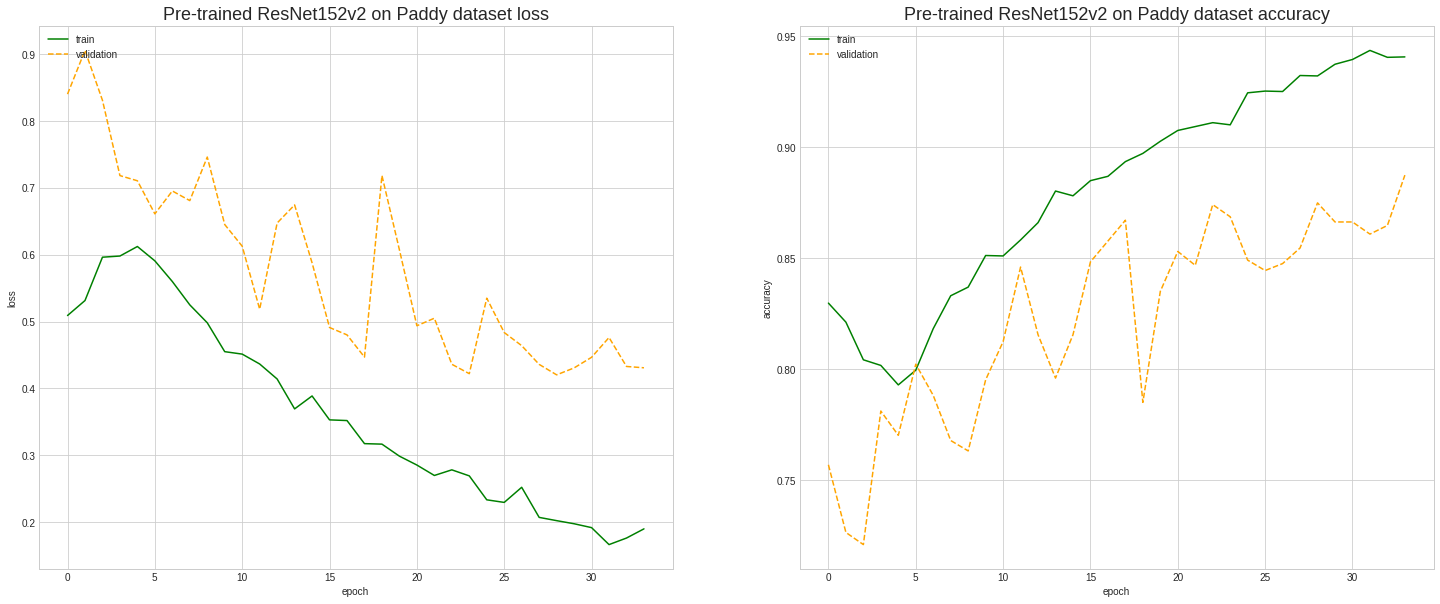

In [ ]:
plot_history(history4, first_score="loss", second_score="accuracy")

In [ ]:
# dense units, batch normalization trainable = false
model.save(
    "/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_fine_tuned_26_416"
)
print("the model is saved")

### fine tuning 26 layers on retrained top layers from v1

In [ ]:
# load model without dense units tuning (model from P8_v1)
model = load_model(
    "/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers_416"
)

In [ ]:
# Fine-tune the model
history4 = model.fit(
    train_generator,
    epochs=epochs_ft,
    validation_data=valid_generator,
    verbose=1,
    callbacks=[early_stp],
)

Epoch 1/200
161/161 [==============================] - 99s 537ms/step - loss: 1.3402 - accuracy: 0.5494 - val_loss: 1.0786 - val_accuracy: 0.6523
Epoch 2/200
161/161 [==============================] - 85s 525ms/step - loss: 0.8826 - accuracy: 0.6993 - val_loss: 0.9539 - val_accuracy: 0.6906
Epoch 3/200
161/161 [==============================] - 83s 517ms/step - loss: 0.7158 - accuracy: 0.7523 - val_loss: 0.8842 - val_accuracy: 0.7117
Epoch 4/200
161/161 [==============================] - 84s 521ms/step - loss: 0.6308 - accuracy: 0.7942 - val_loss: 0.7922 - val_accuracy: 0.7508
Epoch 5/200
161/161 [==============================] - 84s 520ms/step - loss: 0.5860 - accuracy: 0.8117 - val_loss: 0.9102 - val_accuracy: 0.7258
Epoch 6/200
161/161 [==============================] - 83s 514ms/step - loss: 0.5193 - accuracy: 0.8254 - val_loss: 0.7434 - val_accuracy: 0.7742
Epoch 7/200
161/161 [==============================] - 83s 518ms/step - loss: 0.4915 - accuracy: 0.8347 - val_loss: 0.8296 -

better accuracy for this last model, used to send a new submission on the test set

In [ ]:
model.save(
    "/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_adabelief_ranger_2"
)
print("the model is saved")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_adabelief_ranger_2/assets
the model is saved


In [ ]:
# predict sur test set avec resnet_26 layers
disease_pred = model.predict(test_generator, batch_size=32,)

In [ ]:
# formatting Kaggle submission
predicted_class_indices = np.argmax(disease_pred, axis=1)
print(set(predicted_class_indices))

inv_map = {v: k for k, v in train_generator.class_indices.items()}

predictions = [inv_map[k] for k in predicted_class_indices]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [ ]:
filenames = test_generator.filenames

results = pd.DataFrame({"image_id": filenames, "label": predictions})
results.image_id = results.image_id.str.replace("./", "")
results.to_csv("/content/drive/MyDrive/Colab Notebooks/submission5.csv", index=False)
results.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


same accuracy on test set as v1 model : 0.95271